 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 6. MLP Basis**
# Section 3. Tensorflow을 이용한 FeedForward Network 구현하기

### _Objective_
1. 신경망의 기본적인 구조들에 대해 배워보도록 하겠습니다.<br>
2. 활성화 함수에 대해 배워보도록 하겠습니다. <br>
3. 순전파의 과정에 대해 배워보도록 하겠습니다.
  
╚═════════════════════════════════════════╝

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
tf.random.set_random_seed(252)
np.random.seed(100)

import matplotlib.pyplot as plt

### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>

In [2]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## 예제 데이터 ) 암 환자 데이터 셋

In [3]:
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv
cancer_df = pd.read_csv('cancer_dataset.csv')

--2019-04-02 15:09:50--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.58.97
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.58.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2958 (2.9K) [text/csv]
Saving to: ‘cancer_dataset.csv.5’

cancer_dataset.csv. 100%[===================>]   2.89K  --.-KB/s    in 0s      

2019-04-02 15:09:50 (36.6 MB/s) - ‘cancer_dataset.csv.5’ saved [2958/2958]



In [4]:
cancer_df.describe()

,age,tumor_size,label
count,100.000000,100.000000,100.00
mean,4.218584,4.463655,0.45
std,1.949688,2.264897,0.50
min,0.494542,0.656397,0.00
25%,2.750747,2.832193,0.00
50%,3.849528,3.766226,0.00
75%,5.405780,5.921538,1.00
max,9.670666,11.170589,1.00


### 데이터 시각화

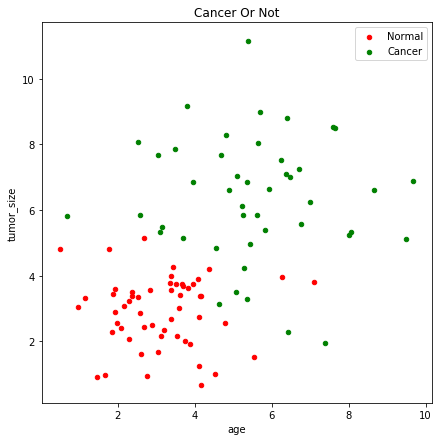

In [5]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# 0: 정상
cancer_df[cancer_df.label==0].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='red')
# 1: 암환자
cancer_df[cancer_df.label==1].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='green')
plt.legend(['Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

<br><br>

# \[ 1. Tensorflow Graph 그리기 \]

----

----

> *이전 시간에 다룬 모델을 텐서플로우로 구현해보도록 하겠습니다.*<br>

<br>

## 1.  placeholder 생성

----

* 위의 모델을 학습시키고, 예측하기 위해서는<br>
  독립 변수(X), 종속 변수(Y), 학습률(learning rate)을 받아오는 placeholder가 필요합니다.

In [6]:
tf.reset_default_graph()

# Data를 받아오는 placeholder
x = tf.placeholder(tf.float32, shape=(None,2), name='x')
y_true = tf.placeholder(tf.float32, shape=(None,1), name="y_true")

학습할 때, 보통 우리는 한번에 여러 개의 데이터를 이용하게 됩니다.<br>
보통 행 단위로 하나의 데이터를 나타내는 것이 관례이기 때문에,<br>
0번째 축을 **None**으로 둡니다.

위와 같이 바뀌면, 수식이 약간 변형이 됩니다.<br>
현대 대부분의 Deep Learning Framework에서는 
$$
y=W\cdot X + b
$$
의 꼴로 구현하기 보다,
$$
y=X\cdot W + b
$$
의 꼴로 구현합니다. 위의 경우는 Theano 프레임워크에서 지원하는 수식의 형태이고,<br>
아래는 Tensorflow, Keras, Pytorch 등에서 이용하는 수식의 형태입니다.

그렇기 때문에, 이전 수식의 행렬들은 모두 전치(transpose)되어야 합니다.

## 2.  weight 생성

----


* 우리는 학습해야 하는 가중치($w_1$,$b_1$,$w_2$,$b_2$)들이 있습니다.<br>

In [7]:
# Weight 초기화
with tf.variable_scope('hidden'):
    w1 = tf.Variable(tf.random.normal([2,100],stddev=0.1),name='weight')
    b1 = tf.Variable(tf.zeros([100,]),name='bias')
    
with tf.variable_scope('output'):
    w2 = tf.Variable(tf.random.normal([100,1],stddev=0.1),name='weight')
    b2 = tf.Variable(tf.zeros([1]),name='bias')

Instructions for updating:
Colocations handled automatically by placer.


## 3. 2층 신경망 구현
----
* 이전 수식들을 구현해야 합니다.
$$
z1 = X\cdot W1 + b1 \\
a1 = \sigma(z1) \\
z2 = a1 \cdot W2 + b2 \\
\hat y = \sigma(z2)
$$

In [8]:
# Y_hat 구하기
with tf.variable_scope('hidden_layer'):
    z1 = tf.matmul(x,w1) + b1
    # sigmoid 대신 활성화 함수로 
    # 더 많이 쓰이는 relu를 적용하겠습니다.
    a1 = tf.nn.relu(z1) 
    
with tf.variable_scope('output_layer'):
    z2 = tf.matmul(a1,w2) + b2
    y_pred = tf.nn.sigmoid(z2) 
output = tf.identity(y_pred,"y_pred")
    
show_graph(tf.get_default_graph())

### (1) RELU 활성화 함수

현대 딥러닝 모델에서는 logistic 함수는 특별한 경우를 제외하고 거의 쓰이지 않고<br>
아래의 relu 함수를 주로 사용합니다.<br>
$
relu(x) = max(x,0)
$

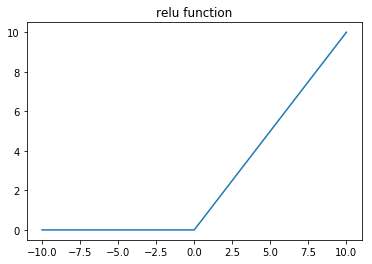

In [9]:
def relu(x):
    return np.maximum(x,0)

xs = np.linspace(-10,10,101)
ys = relu(xs)

plt.title("relu function")
plt.plot(xs,ys)
plt.show()

## 4. 손실함수 구현

---

로지스틱 회귀와 같이 Cross-Entropy를 손실함수로 정하겠습니다.

$$
Loss(W) = \frac{1}{m}\sum_{i=1}^{m}CrossEntropy(y_{true},y_{pred})\\
=- \frac{1}{m}\sum_{i=1}^{m}y_{true}log(y_{pred}) + (1-y_{true})(log(1-y_{pred}))
$$

In [10]:
with tf.variable_scope("loss"):
    crossentropy = -tf.reduce_mean(y_true*tf.log(y_pred+1e-8)
                                   + (1-y_true)*tf.log(1-y_pred+1e-8))
    tf.add_to_collection(tf.GraphKeys.LOSSES,crossentropy)
    
show_graph(tf.get_default_graph())

## 5. Gradient Descent 정의하기
----

심층 신경망을 학습하기 위해서는, BackPropagation(오차 역전파법)에 대한 이해가 필요합니다.<br>
이 내용은 다음 시간(Session 5)에서 다룰 예정이고, 지금은 텐서플로우 API를 이용해서 <br>
이 모델을 학습시키겠습니다.

In [11]:
# 간단히 손실함수를 정의하여 넣는 것으로
# 텐서플로우에서는 자동으로 미분을 계산하여, 정의한 Weight들을 갱신해줍니다.
train_op = (tf.train
            .AdamOptimizer(0.01)
            .minimize(crossentropy))

In [12]:
show_graph(tf.get_default_graph())

## 6. 모델 학습시키기 
----


### (1) 그래프에서 필요한 노드 가져오기

In [13]:
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y_true:0')
y_pred = graph.get_tensor_by_name('y_pred:0')

loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

### (2) 학습할 데이터 가져오기

In [14]:
cancer_df = (cancer_df-cancer_df.min())/(cancer_df.max()-cancer_df.min())

x_1 = cancer_df.tumor_size
x_2 = cancer_df.age
data_X = np.stack([x_1,x_2],axis=1)

data_Y = cancer_df.label.values.reshape(-1,1)

print("X의 shape : {}".format(data_X.shape))
print("Y의 shape : {}".format(data_Y.shape))

X의 shape : (100, 2)
Y의 shape : (100, 1)


### (3) 모델 학습시키기

In [15]:
sess = tf.Session(graph=graph)

# 변수 초기화하기
sess.run(tf.global_variables_initializer())

# 모델 학습시키기
loss_history = []
for epoch in tqdm(range(30000)): 
    _,loss_value = sess.run([train_op, loss],
             feed_dict={
                 x:data_X,
                 y:data_Y
             })
    loss_history.append(loss_value)

100%|██████████| 30000/30000 [00:18<00:00, 1603.65it/s]


### (4) 학습 결과 살펴보기

In [16]:
# 0~1까지의 전체 좌표평면에서 0.01간격으로 점을 가져와 결과를 산출
x1s,x2s = np.mgrid[0:1:0.01,0:1:0.01]
xs = np.stack([x1s.ravel(),x2s.ravel()],axis=1)
results = sess.run(y_pred,
                   feed_dict={x:xs})

# 색 지정
colors = []
for result in results.ravel():
    if result > 0.5:
        colors.append('g')
    else:
        colors.append('r')

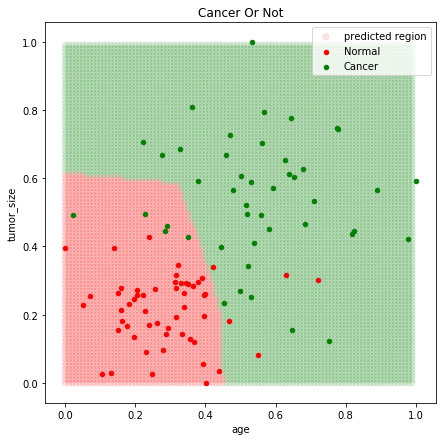

In [17]:
# 결과 그리기
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1],c=colors,alpha=0.1)

# 0: 정상
cancer_df[cancer_df.label==0].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='red')
# 1: 암환자
cancer_df[cancer_df.label==1].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='green')

plt.legend(["predicted region",'Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/01

---